# Scraping the justETF [Screener](https://www.justetf.com/en/find-etf.html)

## Content

- [Request the data](#request)
- [Clean up the data](#cleanup)
- [Enrich the data](#enrich)
- [Save the data](#save)
- [Visualize some statistics](#visualize)
- [Search over the data](#search)

In [54]:
%load_ext nb_black
%load_ext autoreload

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [55]:
%autoreload 1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%aimport utils

<IPython.core.display.Javascript object>

In [56]:
pd.set_option("display.max_columns", None)

<IPython.core.display.Javascript object>

<a id="request"></a>
## Request the data

In [57]:
last_four_years = [
    str((pd.Timestamp("now") - pd.DateOffset(years=i)).year) for i in range(1, 5)
]

<IPython.core.display.Javascript object>

In [58]:
DETAILS_KEY_MAPPING = {
    # IDs
    "isin": "isin",
    "wkn": "wkn",
    "ticker": "ticker",
    "valorNumber": "valor",
    # Basic info
    "name": "name",
    "groupValue": "index",
    "inceptionDate": "date",
    "strategy": "strategy",  # Custom field added during request
    "domicileCountry": "domicile_country",
    "fundCurrency": "currency",
    "hasSecuritiesLending": "securities_lending",
    "distributionPolicy": "dividends",
    "ter": "ter",
    "replicationMethod": "replication",
    "fundSize": "size",
    # Value return
    "ytdReturnCUR": "yesterday",
    "weekReturnCUR": "last_week",
    "monthReturnCUR": "last_month",
    "threeMonthReturnCUR": "last_three_months",
    "sixMonthReturnCUR": "last_six_months",
    "yearReturnCUR": "last_year",
    "threeYearReturnCUR": "last_three_years",
    "fiveYearReturnCUR": "last_five_years",
    "yearReturn1CUR": last_four_years[0],
    "yearReturn2CUR": last_four_years[1],
    "yearReturn3CUR": last_four_years[2],
    "yearReturn4CUR": last_four_years[3],
    # Dividends
    "currentDividendYield": "last_dividends",
    "yearDividendYield": "last_year_dividends",
    # Volatility
    "yearVolatilityCUR": "last_year_volatility",
    "threeYearVolatilityCUR": "last_three_years_volatility",
    "fiveYearVolatilityCUR": "last_five_years_volatility",
    # Return/Risk
    "yearReturnPerRiskCUR": "last_year_return_per_risk",
    "threeYearReturnPerRiskCUR": "last_three_years_return_per_risk",
    "fiveYearReturnPerRiskCUR": "last_five_years_return_per_risk",
    # Ignored fields
    # "groupParam": query for index search, indices are already received
    # "selected": not interesting
    # "clazz": some value, the most are empty strings, some are "highl_c"
    # "savingsPlanReady": "Savings plan ready from x.xx EUR" text
}

<IPython.core.display.Javascript object>

In [59]:
INT64_COLUMNS = ["valor", "size"]
CATEGORY_COLUMNS = ["strategy", "domicile_country", "dividends", "replication"]
FLOAT_COLUMNS = [
    "ter",
    "yesterday",
    "last_week",
    "last_month",
    "last_three_months",
    "last_six_months",
    "last_year",
    "last_three_years",
    "last_five_years",
    "last_dividends",
    "last_year_dividends",
    "last_year_volatility",
    "last_three_years_volatility",
    "last_five_years_volatility",
    "last_year_return_per_risk",
    "last_three_years_return_per_risk",
    "last_five_years_return_per_risk",
] + last_four_years

<IPython.core.display.Javascript object>

In [60]:
data = {key: [] for key in DETAILS_KEY_MAPPING}
for sample in utils.make_request():
    for key, values in data.items():
        values.append(sample[key])

<IPython.core.display.Javascript object>

In [61]:
etf_df = pd.DataFrame(data).rename(columns=DETAILS_KEY_MAPPING)

<IPython.core.display.Javascript object>

In [62]:
etf_df.shape

(2689, 35)

<IPython.core.display.Javascript object>

In [63]:
etf_df.head(3)

,isin,wkn,ticker,valor,name,index,date,strategy,domicile_country,currency,securities_lending,dividends,ter,replication,size,yesterday,last_week,last_month,last_three_months,last_six_months,last_year,last_three_years,last_five_years,2021,2020,2019,2018,last_dividends,last_year_dividends,last_year_volatility,last_three_years_volatility,last_five_years_volatility,last_year_return_per_risk,last_three_years_return_per_risk,last_five_years_return_per_risk
0,CH0496484640,A22FMC,21XA,49648464,21Shares Bitcoin Suisse Index ETP,21Shares Bitcoin Suisse,04.10.19,Long-only,Switzerland,USD,No,Accumulating,2.50%,Physically<br />backed,28,-34.44%,6.63%,-23.80%,-16.44%,-47.22%,-8.81%,-,-,129.88%,252.92%,-,-,-,-,72.14%,-,-,-0.12,-,-
1,CH0445689208,A2TT3D,21XH,44568920,21Shares Crypto Basket Index ETP,21Shares Crypto Basket,21.11.18,Long-only,Switzerland,USD,No,Accumulating,2.50%,Physically<br />backed,111,-47.11%,5.58%,-32.25%,-32.14%,-57.83%,-25.61%,207.22%,-,166.39%,241.24%,20.41%,-,-,-,77.24%,78.25%,-,-0.33,0.58,-
2,IE00B0M62Y33,A0HGWF,IUSJ,2308837,iShares AEX UCITS ETF,AEX®,18.11.05,Long-only,Ireland,EUR,Yes,Distributing,0.30%,Full replication,484,-9.68%,4.65%,0.70%,-1.45%,-7.32%,1.82%,39.50%,52.01%,29.89%,5.14%,27.55%,-8.05%,1.77%,1.77%,18.46%,20.70%,17.65%,0.10,0.57,0.49


<IPython.core.display.Javascript object>

In [64]:
len(etf_df["isin"].unique())

2689

<IPython.core.display.Javascript object>

<a id="cleanup"></a>
## Clean up the data

In [65]:
for column in etf_df:
    etf_df[column] = (
        etf_df[column]
        .str.replace("<br />", " ")
        .str.replace(",", "")
        .replace("-", pd.NA)
    )

<IPython.core.display.Javascript object>

In [66]:
for column in INT64_COLUMNS:
    etf_df[column] = etf_df[column].astype("Int64")

<IPython.core.display.Javascript object>

In [67]:
for column in CATEGORY_COLUMNS:
    etf_df[column] = etf_df[column].astype("category")

<IPython.core.display.Javascript object>

In [68]:
for column in FLOAT_COLUMNS:
    etf_df[column] = (
        etf_df[column].str.removesuffix("%").replace(pd.NA, "nan").astype("float64")
    )

<IPython.core.display.Javascript object>

In [69]:
etf_df["date"] = pd.to_datetime(etf_df["date"], format="%d.%m.%y")

<IPython.core.display.Javascript object>

Keep insertion date, but also calculate age in years to simplify search over dataset.

In [70]:
columns = etf_df.columns.tolist()
etf_df["age"] = (
    pd.Timestamp("now") - pd.to_datetime(etf_df["date"], format="%d.%m.%y")
) / pd.to_timedelta(365, unit="D")
columns.insert(columns.index("date") + 1, "age")
etf_df = etf_df[columns]

<IPython.core.display.Javascript object>

In [71]:
etf_df["securities_lending"] = (
    etf_df["securities_lending"].replace({"Yes": True, "No": False}).astype("bool")
)

<IPython.core.display.Javascript object>

Separate hedged flag from currency.

In [72]:
columns = etf_df.columns.tolist()
columns.insert(columns.index("currency") + 1, "hedged")
etf_df["hedged"] = etf_df["currency"].str.endswith("Hedged")
etf_df["currency"] = etf_df["currency"].str.removesuffix(" Hedged").astype("category")
etf_df = etf_df[columns]

<IPython.core.display.Javascript object>

In [73]:
etf_df.head(3)

,isin,wkn,ticker,valor,name,index,date,age,strategy,domicile_country,currency,hedged,securities_lending,dividends,ter,replication,size,yesterday,last_week,last_month,last_three_months,last_six_months,last_year,last_three_years,last_five_years,2021,2020,2019,2018,last_dividends,last_year_dividends,last_year_volatility,last_three_years_volatility,last_five_years_volatility,last_year_return_per_risk,last_three_years_return_per_risk,last_five_years_return_per_risk
0,CH0496484640,A22FMC,21XA,49648464,21Shares Bitcoin Suisse Index ETP,21Shares Bitcoin Suisse,2019-10-04,2.661270,Long-only,Switzerland,USD,False,False,Accumulating,2.5,Physically backed,28,-34.44,6.63,-23.80,-16.44,-47.22,-8.81,NaN,NaN,129.88,252.92,NaN,NaN,NaN,NaN,72.14,NaN,NaN,-0.12,NaN,NaN
1,CH0445689208,A2TT3D,21XH,44568920,21Shares Crypto Basket Index ETP,21Shares Crypto Basket,2018-11-21,3.529763,Long-only,Switzerland,USD,False,False,Accumulating,2.5,Physically backed,111,-47.11,5.58,-32.25,-32.14,-57.83,-25.61,207.22,NaN,166.39,241.24,20.41,NaN,NaN,NaN,77.24,78.25,NaN,-0.33,0.58,NaN
2,IE00B0M62Y33,A0HGWF,IUSJ,2308837,iShares AEX UCITS ETF,AEX®,2005-11-18,16.546202,Long-only,Ireland,EUR,False,True,Distributing,0.3,Full replication,484,-9.68,4.65,0.70,-1.45,-7.32,1.82,39.50,52.01,29.89,5.14,27.55,-8.05,1.77,1.77,18.46,20.70,17.65,0.10,0.57,0.49


<IPython.core.display.Javascript object>

<a id="enrich"></a>
## Enrich the data

In [74]:
columns = etf_df.columns.tolist()

<IPython.core.display.Javascript object>

In [75]:
etf_df["asset"] = pd.NA
for asset, name in utils.ASSETS.items():
    isins = {sample["isin"] for sample in utils.make_request(asset=asset)}
    mask = etf_df["isin"].isin(isins)
    etf_df.loc[mask, "asset"] = name
etf_df["asset"] = etf_df["asset"].astype("category")

<IPython.core.display.Javascript object>

In [76]:
etf_df["instrument"] = pd.NA
for instrument, name in utils.INSTRUMENTS.items():
    isins = {sample["isin"] for sample in utils.make_request(instrument=instrument)}
    mask = etf_df["isin"].isin(isins)
    etf_df.loc[mask, "instrument"] = name
etf_df["instrument"] = etf_df["instrument"].astype("category")

<IPython.core.display.Javascript object>

In [77]:
etf_df["region"] = pd.NA
for region, name in utils.REGIONS.items():
    isins = {sample["isin"] for sample in utils.make_request(region=region)}
    mask = etf_df["isin"].isin(isins)
    etf_df.loc[mask, "region"] = name
etf_df["region"] = etf_df["region"].astype("category")

<IPython.core.display.Javascript object>

In [78]:
new_columns = ["asset", "instrument", "region"]
for exchange, name in utils.EXCHANGES.items():
    name = f"at_{name}"
    etf_df[name] = False
    new_columns.append(name)
    isins = {sample["isin"] for sample in utils.make_request(exchange=exchange)}
    mask = etf_df["isin"].isin(isins)
    etf_df.loc[mask, name] = True

<IPython.core.display.Javascript object>

In [79]:
etf_df = etf_df[
    columns[: columns.index("size") + 1]
    + new_columns
    + columns[columns.index("size") + 1 :]
]

<IPython.core.display.Javascript object>

In [80]:
etf_df.shape

(2689, 46)

<IPython.core.display.Javascript object>

In [81]:
etf_df.head(3)

,isin,wkn,ticker,valor,name,index,date,age,strategy,domicile_country,currency,hedged,securities_lending,dividends,ter,replication,size,asset,instrument,region,at_gettex,at_xetra,at_london,at_euronext,at_stuttgart,at_six,yesterday,last_week,last_month,last_three_months,last_six_months,last_year,last_three_years,last_five_years,2021,2020,2019,2018,last_dividends,last_year_dividends,last_year_volatility,last_three_years_volatility,last_five_years_volatility,last_year_return_per_risk,last_three_years_return_per_risk,last_five_years_return_per_risk
0,CH0496484640,A22FMC,21XA,49648464,21Shares Bitcoin Suisse Index ETP,21Shares Bitcoin Suisse,2019-10-04,2.661270,Long-only,Switzerland,USD,False,False,Accumulating,2.5,Physically backed,28,Cryptocurrencies,ETN,NaN,True,False,False,False,True,True,-34.44,6.63,-23.80,-16.44,-47.22,-8.81,NaN,NaN,129.88,252.92,NaN,NaN,NaN,NaN,72.14,NaN,NaN,-0.12,NaN,NaN
1,CH0445689208,A2TT3D,21XH,44568920,21Shares Crypto Basket Index ETP,21Shares Crypto Basket,2018-11-21,3.529763,Long-only,Switzerland,USD,False,False,Accumulating,2.5,Physically backed,111,Cryptocurrencies,ETN,NaN,True,True,False,True,False,True,-47.11,5.58,-32.25,-32.14,-57.83,-25.61,207.22,NaN,166.39,241.24,20.41,NaN,NaN,NaN,77.24,78.25,NaN,-0.33,0.58,NaN
2,IE00B0M62Y33,A0HGWF,IUSJ,2308837,iShares AEX UCITS ETF,AEX®,2005-11-18,16.546202,Long-only,Ireland,EUR,False,True,Distributing,0.3,Full replication,484,Equity,ETF,NaN,True,False,True,False,False,True,-9.68,4.65,0.70,-1.45,-7.32,1.82,39.50,52.01,29.89,5.14,27.55,-8.05,1.77,1.77,18.46,20.70,17.65,0.10,0.57,0.49


<IPython.core.display.Javascript object>

<a id="save"></a>
## Save the data

In [82]:
etf_df.to_csv("justetf.csv", index=False)

<IPython.core.display.Javascript object>

<a id="visualize"></a>
## Visualize some statistics

<AxesSubplot:xlabel='Count', ylabel='strategy'>

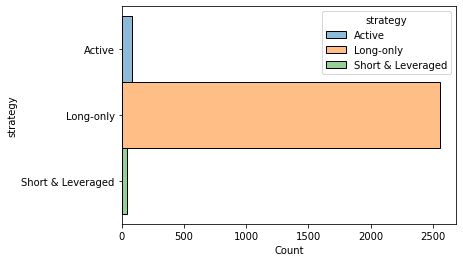

<IPython.core.display.Javascript object>

In [83]:
sns.histplot(etf_df, y="strategy", hue="strategy", discrete=True)

<AxesSubplot:xlabel='Count', ylabel='instrument'>

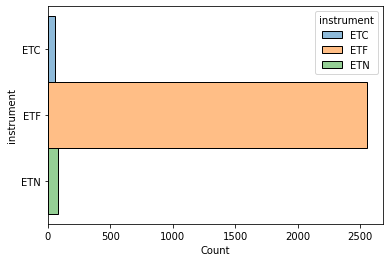

<IPython.core.display.Javascript object>

In [84]:
sns.histplot(etf_df, y="instrument", hue="instrument", discrete=True)

<AxesSubplot:xlabel='Count', ylabel='asset'>

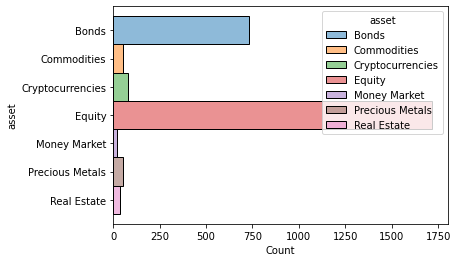

<IPython.core.display.Javascript object>

In [85]:
sns.histplot(etf_df, y="asset", hue="asset", discrete=True)

<AxesSubplot:xlabel='Count', ylabel='region'>

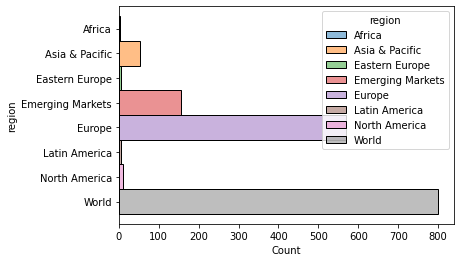

<IPython.core.display.Javascript object>

In [86]:
sns.histplot(etf_df, y="region", hue="region", discrete=True)

<AxesSubplot:xlabel='Count', ylabel='currency'>

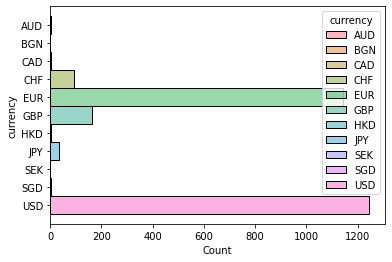

<IPython.core.display.Javascript object>

In [87]:
sns.histplot(etf_df, y="currency", hue="currency", discrete=True)

<AxesSubplot:xlabel='age', ylabel='size'>

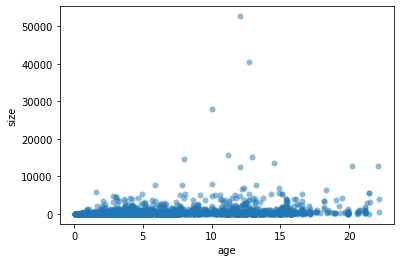

<IPython.core.display.Javascript object>

In [88]:
sns.scatterplot(data=etf_df, x="age", y="size", alpha=0.5, linewidth=0)

The most frequent indices.

In [89]:
index_counts = etf_df["index"].value_counts()

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='Count', ylabel='index'>

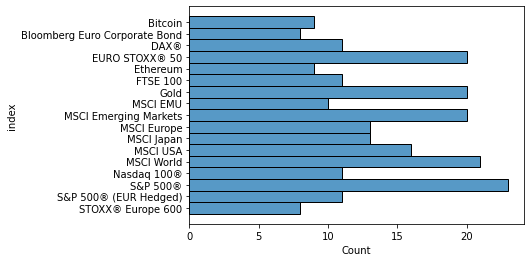

<IPython.core.display.Javascript object>

In [90]:
sns.histplot(
    etf_df[etf_df["index"].isin(index_counts[index_counts > 7].index)],
    y="index",
    discrete=True,
)

<a id="search"></a>
## Search over the data

Compare accumulating MSCI World ETFs older than 2 years with fond size greater than € 50M.

In [91]:
acc_msci_world_df = etf_df[
    (etf_df["index"] == "MSCI World")
    & (etf_df["dividends"] == "Accumulating")
    & (etf_df["age"] > 2)
    & (etf_df["size"] > 50)
]

<IPython.core.display.Javascript object>

In [92]:
acc_msci_world_df.shape

(8, 46)

<IPython.core.display.Javascript object>

In [93]:
acc_msci_world_df

,isin,wkn,ticker,valor,name,index,date,age,strategy,domicile_country,currency,hedged,securities_lending,dividends,ter,replication,size,asset,instrument,region,at_gettex,at_xetra,at_london,at_euronext,at_stuttgart,at_six,yesterday,last_week,last_month,last_three_months,last_six_months,last_year,last_three_years,last_five_years,2021,2020,2019,2018,last_dividends,last_year_dividends,last_year_volatility,last_three_years_volatility,last_five_years_volatility,last_year_return_per_risk,last_three_years_return_per_risk,last_five_years_return_per_risk
1606,LU1437016972,A2ATYV,XPAN,34333476,Amundi ETF MSCI World UCITS ETF DR,MSCI World,2016-11-17,5.540722,Long-only,Luxembourg,EUR,False,True,Accumulating,0.18,Full replication,519,Equity,ETF,World,True,False,True,True,False,False,-8.44,3.94,-1.82,-1.74,-4.25,7.83,47.82,65.66,31.51,6.34,30.97,-4.99,NaN,NaN,15.76,20.03,17.03,0.50,0.69,0.62
1609,LU1681043599,A2H59Q,AMEW,38784696,Amundi MSCI World UCITS ETF EUR (C),MSCI World,2018-04-18,4.124284,Long-only,Luxembourg,EUR,False,False,Accumulating,0.38,Swap based Unfunded,2125,Equity,ETF,World,True,True,False,True,True,True,-7.98,3.91,-1.81,-1.53,-5.04,8.13,47.75,65.53,30.94,6.26,29.84,-4.19,NaN,NaN,15.06,19.70,16.83,0.54,0.70,0.63
1612,IE00B60SX394,A0RGCS,SC0J,10128224,Invesco MSCI World UCITS ETF,MSCI World,2009-04-02,13.173599,Long-only,Ireland,USD,False,False,Accumulating,0.19,Swap based Unfunded,3085,Equity,ETF,World,True,True,True,False,True,True,-8.19,3.93,-1.79,-1.69,-3.95,8.22,48.98,67.08,32.10,6.28,30.38,-4.29,NaN,NaN,15.55,20.24,17.22,0.53,0.70,0.63
1613,IE00B4L5Y983,A0RPWH,EUNL,10608388,iShares Core MSCI World UCITS ETF USD (Acc),MSCI World,2009-09-25,12.691407,Long-only,Ireland,USD,False,True,Accumulating,0.20,Optimized sampling,40521,Equity,ETF,World,True,True,True,False,True,True,-8.13,3.92,-1.78,-1.63,-3.88,8.54,48.73,66.77,32.08,6.13,30.22,-4.30,NaN,NaN,15.66,20.21,17.27,0.55,0.70,0.62
1615,LU1781541179,LYX0YD,LCUW,40587053,Lyxor Core MSCI World (DR) UCITS ETF - Acc,MSCI World,2018-02-28,4.258530,Long-only,Luxembourg,USD,False,False,Accumulating,0.12,Optimized sampling,1819,Equity,ETF,World,True,True,True,True,True,False,-8.26,4.01,-1.78,-1.71,-3.99,8.09,48.21,NaN,31.96,6.12,29.92,NaN,NaN,NaN,15.42,20.14,NaN,0.52,0.70,NaN
1619,IE00BFY0GT14,A2N6CW,SPPW,46170158,SPDR MSCI World UCITS ETF,MSCI World,2019-02-28,3.258530,Long-only,Ireland,USD,False,False,Accumulating,0.12,Optimized sampling,1400,Equity,ETF,World,True,True,True,False,False,True,-7.92,3.98,-1.71,-1.49,-3.65,8.47,49.04,NaN,32.15,6.01,NaN,NaN,NaN,NaN,15.52,20.14,NaN,0.55,0.71,NaN
1623,LU0274208692,DBX1MW,DBXW,2825395,Xtrackers MSCI World Swap UCITS ETF 1C,MSCI World,2006-12-19,15.461270,Long-only,Luxembourg,USD,False,False,Accumulating,0.45,Swap based Unfunded,3058,Equity,ETF,World,True,True,True,False,True,True,-8.31,3.88,-1.88,-1.79,-4.07,8.33,48.38,66.45,31.91,6.14,31.27,-5.57,NaN,NaN,15.47,20.16,17.20,0.54,0.70,0.62
1625,IE00BJ0KDQ92,A1XB5U,XDWD,24869934,Xtrackers MSCI World UCITS ETF 1C,MSCI World,2014-07-22,7.866750,Long-only,Ireland,USD,False,True,Accumulating,0.19,Optimized sampling,7825,Equity,ETF,World,True,True,True,False,True,True,-8.18,3.95,-1.79,-1.66,-3.94,8.51,48.65,66.67,32.04,6.19,31.14,-5.54,NaN,NaN,15.53,20.14,17.15,0.55,0.70,0.63


<IPython.core.display.Javascript object>

In [94]:
COLUMNS_MAPPINGS = {
    "Short-term return": {
        "isin": "isin",
        "last_six_months": "Last 5 months",
        "last_three_months": "Last 3 months",
        "last_month": "Last month",
        "last_week": "Last week",
        "yesterday": "Yesterday",
    },
    "Mid-term return": {
        "isin": "isin",
        "last_five_years": "last 5 years",
        "last_three_years": "last 3 years",
        "last_year": "last year",
    },
    "Volatility": {
        "isin": "isin",
        "last_five_years_volatility": "Last 5 years",
        "last_three_years_volatility": "Last 3 years",
        "last_year_volatility": "Last year",
    },
    "Return/Risk": {
        "isin": "isin",
        "last_five_years_return_per_risk": "Last 5 years",
        "last_three_years_return_per_risk": "Last 3 years",
        "last_year_return_per_risk": "Last year",
    },
}

<IPython.core.display.Javascript object>

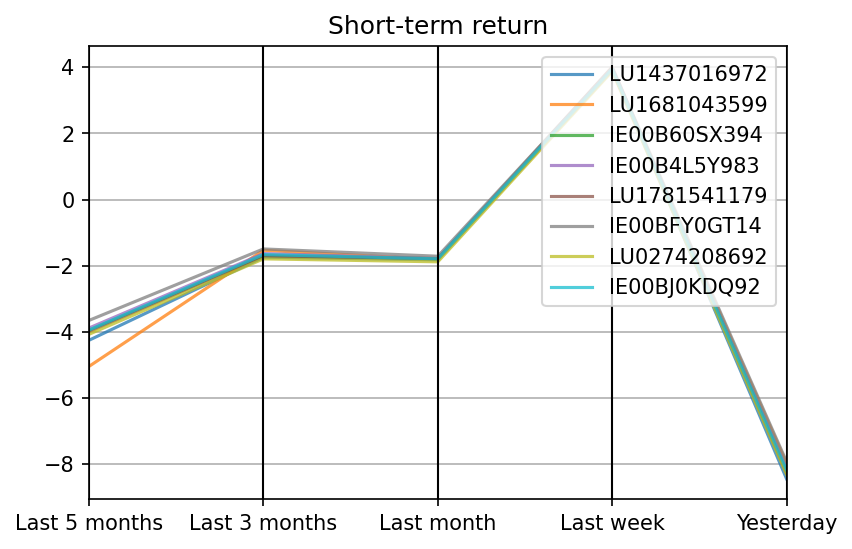

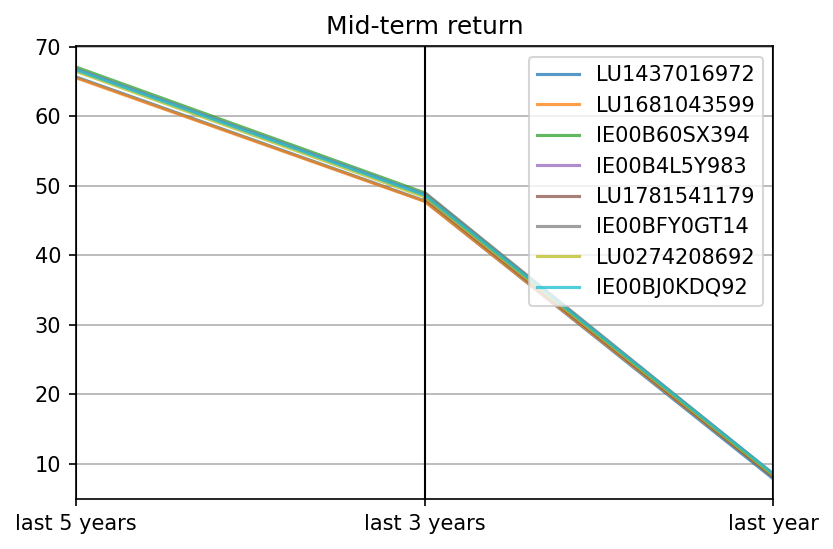

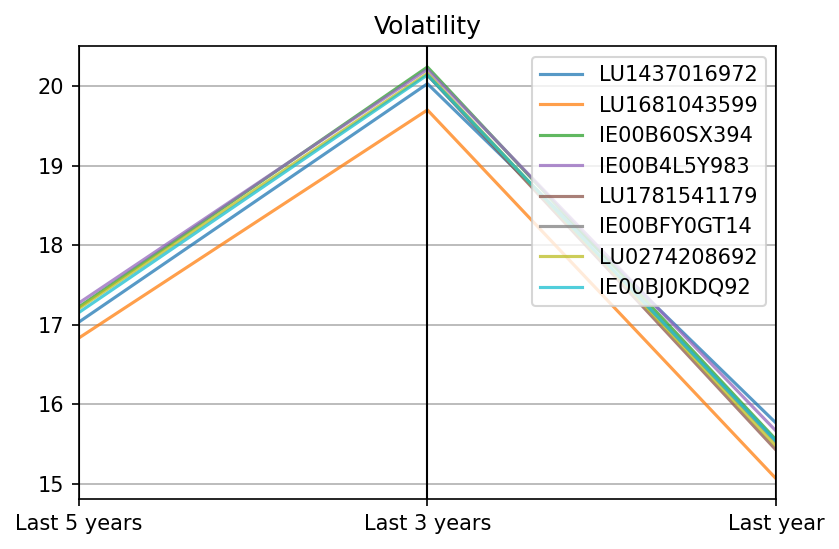

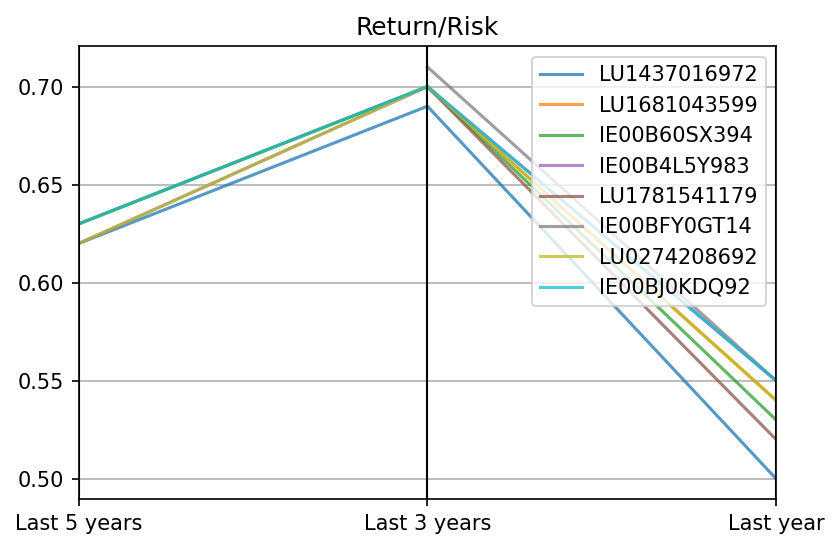

<IPython.core.display.Javascript object>

In [95]:
for title, mapping in COLUMNS_MAPPINGS.items():
    df = acc_msci_world_df[mapping.keys()].rename(columns=mapping)
    plt.figure(dpi=150)
    ax = pd.plotting.parallel_coordinates(df, "isin", colormap="tab10", alpha=0.75)
    _ = ax.set_title(title)

In [96]:
df = acc_msci_world_df[["isin"] + list(reversed(last_four_years))]

<IPython.core.display.Javascript object>

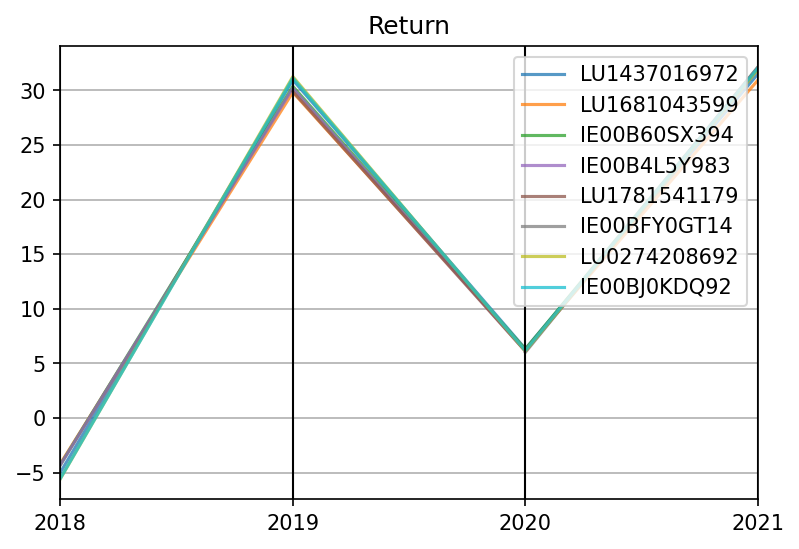

<IPython.core.display.Javascript object>

In [97]:
plt.figure(dpi=150)
ax = pd.plotting.parallel_coordinates(df, "isin", colormap="tab10", alpha=0.75)
_ = ax.set_title("Return")

In [98]:
df = df.set_index("isin")

<IPython.core.display.Javascript object>

In [99]:
ter = (100 - acc_msci_world_df.set_index("isin")["ter"]) / 100

<IPython.core.display.Javascript object>

In [100]:
df = ((100 + df) / 100).mul(ter, axis=0)

<IPython.core.display.Javascript object>

In [101]:
cum_df = df.copy()

<IPython.core.display.Javascript object>

In [102]:
df = (df * 100 - 100).reset_index()

<IPython.core.display.Javascript object>

In [103]:
cum_df[last_four_years[1]] *= cum_df[last_four_years[0]]
cum_df[last_four_years[2]] *= cum_df[last_four_years[1]]
cum_df[last_four_years[3]] *= cum_df[last_four_years[2]]

<IPython.core.display.Javascript object>

In [104]:
cum_df = (cum_df * 100 - 100).reset_index()

<IPython.core.display.Javascript object>

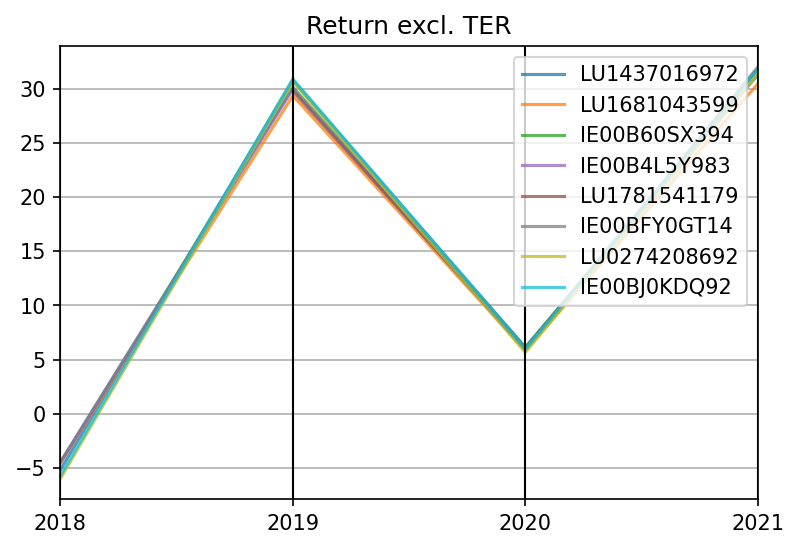

<IPython.core.display.Javascript object>

In [105]:
plt.figure(dpi=150)
ax = pd.plotting.parallel_coordinates(df, "isin", colormap="tab10", alpha=0.75)
_ = ax.set_title("Return excl. TER")

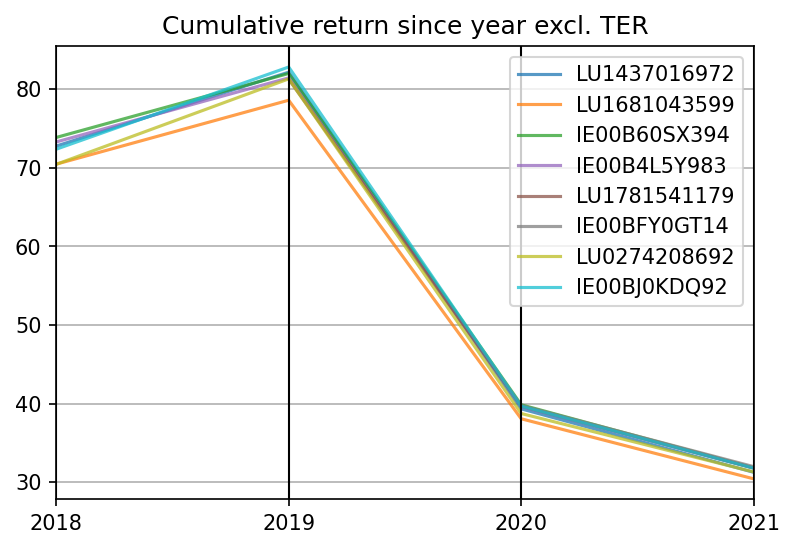

<IPython.core.display.Javascript object>

In [106]:
plt.figure(dpi=150)
ax = pd.plotting.parallel_coordinates(cum_df, "isin", colormap="tab10", alpha=0.75)
_ = ax.set_title("Cumulative return since year excl. TER")